## Going through pytorch/examples implementation


In [73]:
import random 
import math

import numba
import numpy as np
import torch
from torch import nn
from torch.distributions import Categorical
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from madigan.environments import make_env
from madigan.environments.cpp import Broker, Synth, Env as EnvC
from madigan.environments.cpp import Assets, RiskInfo, EnvInfoMulti, EnvInfoSingle

from madigan.fleet import make_agent

from madigan.utils.preprocessor import make_preprocessor as _make_preprocessor
from madigan.fleet.conv_model import calc_conv_out_shape
from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [151]:
eps = np.finfo(np.float32).eps.item()

class ActorCritic(nn.Module):
    def __init__(self, env, config, feature_input_size=64, d_model=128, nactions=2, discount=0.99,
                lr=1e-2, nassets=1):
        super().__init__()
        self.env = env
        self.config=config
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        out_shape = calc_conv_out_shape(feature_input_size, [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        self.dropout = nn.Dropout(0.3)
        self.policy_head = nn.Linear(d_model, 3)
        self.value_head = nn.Linear(d_model, 1)
        self.act = nn.GELU()             
        
        self.action_atoms = config.discrete_action_atoms
        self.discount = discount
        self.opt = optim.Adam(self.parameters(), lr=lr)
        
        self.logp_mem = []
        self.state_val_mem = []
        self.reward_mem = []
        
    def prep_state(self, state):
        price = torch.as_tensor(state.price[None, ...], dtype=torch.float32)
        port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32)
        return price, port
    
    def _forward(self, state):        
        price, port = self.prep_state(state)
        price = price.transpose(-1, -2)
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)
        full_emb = torch.cat([price_emb, port], dim=-1)
        full_emb = self.act(self.fc1(full_emb))
        scores = self.policy_head(full_emb)
        state_val = self.value_head(full_emb)
        probs = F.softmax(scores, dim=-1)
        return probs, state_val
        
    def __call__(self, state):
        action = self.get_action(state)
        return action
    
    def get_action(self, state=None, state_emb=None):
        probs, state_val = self._forward(state)
        policy_dist = Categorical(probs)
        action = policy_dist.sample()
        self.logp_mem.append(policy_dist.log_prob(action))
        self.state_val_mem.append(state_val[0])
        return self.action_to_transaction(action)
    
    def get_policy(self, state):
        probs, val = self._forward(state)
        return Categorical(probs)
    
    def get_state_value(self, state):
        probs, val = self._forward(state)
        return val
    
    def action_to_transaction(self, actions):
        units = 0.1 * self.env.availableMargin / self.env.currentPrices
        actions_ternary = (actions - (self.action_atoms // 2)).cpu().numpy()
        return units * actions_ternary
    
    def train_step(self):
        R = 0
        policy_loss = []
        value_loss  = []
        returns = []
        for r in self.reward_mem[::-1]:
            R = r + self.discount*R
            returns.append(R)
        returns.reverse()
        returns = torch.tensor(returns)
        returns = (returns-returns.mean())/ (returns.std() + eps)
        
        for log_p, value, R in zip(self.logp_mem, self.state_val_mem, returns):
            adv = R - value.item()
            policy_loss.append(-log_p * adv)
            value_loss.append(F.smooth_l1_loss(value, torch.tensor([R])))
            
        self.opt.zero_grad()
        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
        loss.backward()
        self.opt.step()
        
        self.logp_mem.clear()
        self.reward_mem.clear()
        self.state_val_mem.clear()
        return loss.detach().item()
        

In [172]:
def train(env, policy, preprocessor, render=False, max_episodes=1000, log_interval=5):
    
    max_steps = 1000
    
    rewards = []
    running_reward = 10
    losses = []
    running_loss = 0.
    i=0
    try:
        while True:
            _state = env.reset()
            preprocessor.stream_state(_state)
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
            
            ep_reward = 0
            for t in range(1, max_steps):
                action = policy.get_action(state)
                _state, reward, done, _ = env.step(action)
                preprocessor.stream_state(_state)

                if render:
                    env.render()

                policy.reward_mem.append(reward)
                ep_reward += reward

                if done:
                    break
            
            loss = policy.train_step()
            
            running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
            running_loss = 0.05 * loss + (1-0.05) * running_loss
            rewards.append(running_reward)
            losses.append(loss)
            
            if i % log_interval == 0:
                print('='*80)
                print(f'ep number: {i} current episode steps: {t}')
                print(f'last ep reward: {ep_reward:} running reward: {running_reward:.2f}',
                      f'last loss: {loss:.2f} running loss: {running_loss:.2f}',)
            if i >= max_episodes:
                print('max episoes reached')
                break
#             if running_reward >= 200:
#                 policy.opt.lr = 1e-3
            i += 1
    except KeyboardInterrupt:
        pass
    
    return losses, rewards
        
    

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        test_steps=1_000,
        nsteps=1_000_000,
        transaction_cost_rel=0.01,
    
        assets=["OU1"],
#         data_source_type="SineAdder",
#         generator_params={
#             'freq':[2.2, 4.1, 1., 3.],
#             'mu':[.6, 0.3, 2., 4.2],
#             'amp':[.5, 0.2, 0.4, 1.2],
#             'phase':[0., 1., 4., 0.],
#             'dX':0.01,
#             "noise": 0.0},
        data_source_type="OU",
        generator_params=dict(
            mean=[10.],
            theta=[.15],
            phi = [1.],
            noise_var = [.1],
            
        ),
    
        preprocessor_type="WindowedStacker",
        window_length=64,
    
        agent_type = "A2C",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        nstep_return = 3,
        target_update_freq=12000,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=32,
        discount = 0.999,
        lot_unit_value=100_000,
    
    
        model_class="ConvModel",
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.01,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'OU',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'mean': [10.0],
  'theta': [0.15],
  'phi': [1.0],
  'noise_var': [0.1]},
 'assets': ['OU1'],
 'lot_unit_value': 100000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'A2C',
 'agent_config': {'type': 'A2C',
  'basepath': '/media/hemu/Data/Markets/farm',
  'discrete_action_atoms': 3,
  'model_config': {'model_class': 'ConvModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feats': 1,
   'action_atoms': 3,
   'n_assets': 1,
   'min_tf': 64,
   'dueling': False,
   'iqn': False,
   'nTau1': 32,
   'nT

In [168]:
discount=0.99
lr=1e-5

env = make_env(config)
policy = ActorCritic(env, config, discount=discount, lr=lr)
preprocessor = _make_preprocessor(config)

In [174]:
losses, rewards = train(env, policy, preprocessor, max_episodes=10_000, render=False, log_interval=10)

ep number: 0 current episode steps: 726
last ep reward: -2.0736531686074082 running reward: 9.40 last loss: 142.95 running loss: 7.15
ep number: 10 current episode steps: 730
last ep reward: -1.6695301462858683 running reward: 4.90 last loss: 124.68 running loss: 52.11
ep number: 20 current episode steps: 530
last ep reward: -1.662922217791932 running reward: 2.18 last loss: 98.09 running loss: 78.73
ep number: 30 current episode steps: 645
last ep reward: -1.9522300517674014 running reward: 0.60 last loss: 134.28 running loss: 100.09
ep number: 40 current episode steps: 645
last ep reward: -1.7257963694174219 running reward: -0.44 last loss: 127.38 running loss: 106.28
ep number: 50 current episode steps: 530
last ep reward: -1.7841326848818164 running reward: -0.97 last loss: 120.31 running loss: 109.65
ep number: 60 current episode steps: 645
last ep reward: -1.7723195722893579 running reward: -1.38 last loss: 126.25 running loss: 114.20
ep number: 70 current episode steps: 726
last

ep number: 380 current episode steps: 485
last ep reward: -0.0027398988572658045 running reward: -0.02 last loss: 169.67 running loss: 116.37
ep number: 390 current episode steps: 169
last ep reward: -0.05433275054907946 running reward: -0.02 last loss: 57.44 running loss: 102.13
ep number: 400 current episode steps: 317
last ep reward: -0.002933087968088657 running reward: -0.02 last loss: 119.20 running loss: 88.05
ep number: 410 current episode steps: 102
last ep reward: -0.00426223817544809 running reward: -0.02 last loss: 37.25 running loss: 85.41
ep number: 420 current episode steps: 132
last ep reward: -0.009697275115492846 running reward: -0.02 last loss: 44.64 running loss: 79.76
ep number: 430 current episode steps: 999
last ep reward: 0.0013697837729702775 running reward: -0.01 last loss: 356.62 running loss: 137.86
ep number: 440 current episode steps: 999
last ep reward: -0.0551978285509956 running reward: -0.01 last loss: 417.40 running loss: 204.16
ep number: 450 current

ep number: 760 current episode steps: 138
last ep reward: -0.02491878261976153 running reward: -0.31 last loss: 70.75 running loss: 302.76
ep number: 770 current episode steps: 999
last ep reward: -0.059140721256384074 running reward: -0.19 last loss: 397.35 running loss: 312.49
ep number: 780 current episode steps: 999
last ep reward: -0.030751825744854477 running reward: -0.12 last loss: 388.64 running loss: 280.07
ep number: 790 current episode steps: 808
last ep reward: -1.8814521251012368 running reward: -0.17 last loss: 284.30 running loss: 257.21
ep number: 800 current episode steps: 999
last ep reward: 0.07139938241313133 running reward: -0.10 last loss: 405.94 running loss: 266.77
ep number: 810 current episode steps: 139
last ep reward: -0.023860470335806076 running reward: -0.08 last loss: 64.24 running loss: 265.54
ep number: 820 current episode steps: 320
last ep reward: -0.03241407568455882 running reward: -0.05 last loss: 125.29 running loss: 211.99
ep number: 830 curren

ep number: 1140 current episode steps: 808
last ep reward: -1.816909729918402 running reward: -1.53 last loss: 204.73 running loss: 186.35
ep number: 1150 current episode steps: 999
last ep reward: -0.05423335023502607 running reward: -1.28 last loss: 240.32 running loss: 179.74
ep number: 1160 current episode steps: 999
last ep reward: -0.0545601465476058 running reward: -0.77 last loss: 494.45 running loss: 239.14
ep number: 1170 current episode steps: 999
last ep reward: 0.017729234868186443 running reward: -0.53 last loss: 463.52 running loss: 290.48
ep number: 1180 current episode steps: 999
last ep reward: -0.01129646596742552 running reward: -0.33 last loss: 360.57 running loss: 313.35
ep number: 1190 current episode steps: 999
last ep reward: -0.0386244197443104 running reward: -0.27 last loss: 368.85 running loss: 336.12
ep number: 1200 current episode steps: 999
last ep reward: 0.04465357206374288 running reward: -0.33 last loss: 390.73 running loss: 309.73
ep number: 1210 cu

ep number: 1510 current episode steps: 398
last ep reward: -0.03148207611834965 running reward: -0.02 last loss: 138.84 running loss: 87.20
ep number: 1520 current episode steps: 251
last ep reward: -0.055759174813610236 running reward: -0.02 last loss: 88.36 running loss: 87.03
ep number: 1530 current episode steps: 317
last ep reward: -0.04272575976254413 running reward: -0.03 last loss: 96.94 running loss: 80.13
ep number: 1540 current episode steps: 166
last ep reward: -0.012110721898166626 running reward: -0.02 last loss: 55.24 running loss: 72.44
ep number: 1550 current episode steps: 137
last ep reward: -0.002082706038698789 running reward: -0.02 last loss: 44.69 running loss: 65.50
ep number: 1560 current episode steps: 138
last ep reward: -0.030182024763870455 running reward: -0.02 last loss: 48.84 running loss: 76.16
ep number: 1570 current episode steps: 138
last ep reward: -0.03056885860434658 running reward: -0.03 last loss: 44.23 running loss: 84.53
ep number: 1580 curren

ep number: 1890 current episode steps: 139
last ep reward: -0.02980463875211868 running reward: -0.02 last loss: 45.55 running loss: 83.92
ep number: 1900 current episode steps: 221
last ep reward: -0.02902919475341205 running reward: -0.02 last loss: 70.54 running loss: 90.40
ep number: 1910 current episode steps: 138
last ep reward: -0.04198248025967166 running reward: -0.02 last loss: 56.96 running loss: 83.86
ep number: 1920 current episode steps: 138
last ep reward: -0.019573099717385092 running reward: -0.03 last loss: 59.93 running loss: 85.49
ep number: 1930 current episode steps: 398
last ep reward: -0.027572876987598083 running reward: -0.02 last loss: 121.84 running loss: 84.90
ep number: 1940 current episode steps: 487
last ep reward: -0.01511415472783655 running reward: -0.02 last loss: 139.82 running loss: 79.69
ep number: 1950 current episode steps: 469
last ep reward: -0.03771956339483615 running reward: -0.02 last loss: 119.75 running loss: 76.21
ep number: 1960 curren

ep number: 2260 current episode steps: 999
last ep reward: 0.007964586455541562 running reward: -0.02 last loss: 412.91 running loss: 247.91
ep number: 2270 current episode steps: 320
last ep reward: -0.03834777087978729 running reward: -0.02 last loss: 105.87 running loss: 248.89
ep number: 2280 current episode steps: 999
last ep reward: -0.02698354963410161 running reward: -0.02 last loss: 366.65 running loss: 235.63
ep number: 2290 current episode steps: 235
last ep reward: -0.0416253118754287 running reward: -0.02 last loss: 98.77 running loss: 223.80
ep number: 2300 current episode steps: 343
last ep reward: -0.014338458628462409 running reward: -0.03 last loss: 105.18 running loss: 228.11
ep number: 2310 current episode steps: 999
last ep reward: -0.0245512969961711 running reward: -0.02 last loss: 334.66 running loss: 203.35
ep number: 2320 current episode steps: 228
last ep reward: -0.03143211031272519 running reward: -0.03 last loss: 71.93 running loss: 165.76
ep number: 2330 

ep number: 2630 current episode steps: 566
last ep reward: -0.029953155369137317 running reward: -0.03 last loss: 237.45 running loss: 209.95
ep number: 2640 current episode steps: 520
last ep reward: -0.02881731976087222 running reward: -0.03 last loss: 152.31 running loss: 214.89
ep number: 2650 current episode steps: 711
last ep reward: -0.030324680968331203 running reward: -0.03 last loss: 316.46 running loss: 240.29
ep number: 2660 current episode steps: 940
last ep reward: -0.022573070125538577 running reward: -0.02 last loss: 332.89 running loss: 277.72
ep number: 2670 current episode steps: 937
last ep reward: -0.031343831918930545 running reward: -0.02 last loss: 348.41 running loss: 299.75
ep number: 2680 current episode steps: 999
last ep reward: -0.007153206271938727 running reward: -0.02 last loss: 406.91 running loss: 308.23
ep number: 2690 current episode steps: 999
last ep reward: -0.011372530206176623 running reward: -0.02 last loss: 351.33 running loss: 306.19
ep numb

ep number: 3000 current episode steps: 999
last ep reward: 0.01322807488030408 running reward: 0.00 last loss: 362.46 running loss: 386.55
ep number: 3010 current episode steps: 999
last ep reward: -0.0035029286574014187 running reward: 0.00 last loss: 393.94 running loss: 391.97
ep number: 3020 current episode steps: 999
last ep reward: -0.004065205203239304 running reward: 0.00 last loss: 333.28 running loss: 388.47
ep number: 3030 current episode steps: 999
last ep reward: -0.003174096650829787 running reward: 0.00 last loss: 390.30 running loss: 395.71
ep number: 3040 current episode steps: 999
last ep reward: -0.0007941101729070196 running reward: 0.00 last loss: 394.19 running loss: 389.95
ep number: 3050 current episode steps: 999
last ep reward: -0.008145720362089309 running reward: 0.00 last loss: 377.03 running loss: 394.50
ep number: 3060 current episode steps: 999
last ep reward: 0.0031574776809895665 running reward: 0.00 last loss: 381.73 running loss: 393.50
ep number: 30

ep number: 3370 current episode steps: 236
last ep reward: -0.04750138240692889 running reward: -0.02 last loss: 111.08 running loss: 257.76
ep number: 3380 current episode steps: 507
last ep reward: -0.028723215135066035 running reward: -0.02 last loss: 213.67 running loss: 257.02
ep number: 3390 current episode steps: 520
last ep reward: -0.029509624076244256 running reward: -0.02 last loss: 204.46 running loss: 237.29
ep number: 3400 current episode steps: 398
last ep reward: -0.023633859579652056 running reward: -0.02 last loss: 140.29 running loss: 224.87
ep number: 3410 current episode steps: 566
last ep reward: -0.031222203989431832 running reward: -0.02 last loss: 194.11 running loss: 232.97
ep number: 3420 current episode steps: 868
last ep reward: -0.033186735877689034 running reward: -0.02 last loss: 232.28 running loss: 240.51
ep number: 3430 current episode steps: 999
last ep reward: -0.013830576927031192 running reward: -0.02 last loss: 344.16 running loss: 243.06
ep numb

ep number: 3740 current episode steps: 999
last ep reward: 0.0002459753701715729 running reward: -0.02 last loss: 347.23 running loss: 327.94
ep number: 3750 current episode steps: 869
last ep reward: -0.035642005703786166 running reward: -0.02 last loss: 328.47 running loss: 313.33
ep number: 3760 current episode steps: 678
last ep reward: -0.03769588860277769 running reward: -0.02 last loss: 248.34 running loss: 320.15
ep number: 3770 current episode steps: 869
last ep reward: -0.030644033786116784 running reward: -0.02 last loss: 315.19 running loss: 312.62
ep number: 3780 current episode steps: 940
last ep reward: -0.027022364111744235 running reward: -0.02 last loss: 341.21 running loss: 324.58
ep number: 3790 current episode steps: 999
last ep reward: -0.007284060027956389 running reward: -0.02 last loss: 274.33 running loss: 308.13
ep number: 3800 current episode steps: 999
last ep reward: 0.0028007226859372864 running reward: -0.02 last loss: 361.84 running loss: 321.56
ep numb

ep number: 4110 current episode steps: 710
last ep reward: -0.024014784714372066 running reward: -0.01 last loss: 255.89 running loss: 374.24
ep number: 4120 current episode steps: 999
last ep reward: -0.01287767707133166 running reward: -0.01 last loss: 321.46 running loss: 369.82
ep number: 4130 current episode steps: 999
last ep reward: -0.000870513287181008 running reward: -0.01 last loss: 356.23 running loss: 358.31
ep number: 4140 current episode steps: 789
last ep reward: -0.02926553502035197 running reward: -0.01 last loss: 297.73 running loss: 357.86
ep number: 4150 current episode steps: 999
last ep reward: 0.014553281624414511 running reward: -0.01 last loss: 402.30 running loss: 363.67
ep number: 4160 current episode steps: 999
last ep reward: -0.02368775593705951 running reward: -0.01 last loss: 374.75 running loss: 373.89
ep number: 4170 current episode steps: 999
last ep reward: 0.0005297405351286514 running reward: -0.01 last loss: 415.57 running loss: 376.38
ep number:

ep number: 4480 current episode steps: 999
last ep reward: 0.003997292613125822 running reward: 0.00 last loss: 407.96 running loss: 384.95
ep number: 4490 current episode steps: 999
last ep reward: -0.0035156471551676676 running reward: -0.00 last loss: 397.22 running loss: 387.70
ep number: 4500 current episode steps: 999
last ep reward: 0.0042879380943600005 running reward: 0.00 last loss: 379.17 running loss: 387.78
ep number: 4510 current episode steps: 999
last ep reward: -0.00029421355912893476 running reward: 0.00 last loss: 414.44 running loss: 392.11
ep number: 4520 current episode steps: 999
last ep reward: -0.001876091398338425 running reward: 0.00 last loss: 366.71 running loss: 393.59
ep number: 4530 current episode steps: 937
last ep reward: -0.028509510901731726 running reward: -0.00 last loss: 325.20 running loss: 384.72
ep number: 4540 current episode steps: 999
last ep reward: -0.0007352440125833401 running reward: 0.00 last loss: 468.05 running loss: 393.61
ep numbe

ep number: 4850 current episode steps: 999
last ep reward: 0.004478024463390072 running reward: -0.01 last loss: 423.73 running loss: 359.92
ep number: 4860 current episode steps: 999
last ep reward: 0.0049425974551546925 running reward: -0.01 last loss: 344.04 running loss: 367.48
ep number: 4870 current episode steps: 999
last ep reward: 0.00641093384719503 running reward: -0.01 last loss: 410.90 running loss: 360.57
ep number: 4880 current episode steps: 999
last ep reward: -0.003972049929485771 running reward: -0.01 last loss: 384.44 running loss: 354.85
ep number: 4890 current episode steps: 999
last ep reward: -0.0011225524614059046 running reward: -0.01 last loss: 360.39 running loss: 367.77
ep number: 4900 current episode steps: 711
last ep reward: -0.0332897255872419 running reward: -0.01 last loss: 253.72 running loss: 369.08
ep number: 4910 current episode steps: 999
last ep reward: -0.00013746731591850105 running reward: -0.01 last loss: 366.73 running loss: 361.15
ep numbe

ep number: 5220 current episode steps: 999
last ep reward: 0.0006579011967775862 running reward: -0.00 last loss: 379.94 running loss: 388.34
ep number: 5230 current episode steps: 999
last ep reward: 0.009554707078971904 running reward: 0.00 last loss: 402.90 running loss: 386.91
ep number: 5240 current episode steps: 999
last ep reward: 0.0017763033669485335 running reward: 0.00 last loss: 392.49 running loss: 386.86
ep number: 5250 current episode steps: 999
last ep reward: -0.005112746668810458 running reward: 0.00 last loss: 380.81 running loss: 391.44
ep number: 5260 current episode steps: 999
last ep reward: -0.007973023180855236 running reward: -0.00 last loss: 356.93 running loss: 386.78
ep number: 5270 current episode steps: 999
last ep reward: -2.6854051438230178e-05 running reward: -0.00 last loss: 391.41 running loss: 388.41
ep number: 5280 current episode steps: 999
last ep reward: 0.004813415357315581 running reward: -0.00 last loss: 403.88 running loss: 395.39
ep number

ep number: 5590 current episode steps: 999
last ep reward: -0.007674176220331415 running reward: -0.00 last loss: 351.90 running loss: 384.20
ep number: 5600 current episode steps: 999
last ep reward: -0.004652019017035066 running reward: -0.00 last loss: 396.38 running loss: 383.97
ep number: 5610 current episode steps: 999
last ep reward: -0.004107458032808152 running reward: -0.00 last loss: 388.99 running loss: 387.73
ep number: 5620 current episode steps: 999
last ep reward: 0.004105793281727035 running reward: 0.00 last loss: 413.83 running loss: 389.19


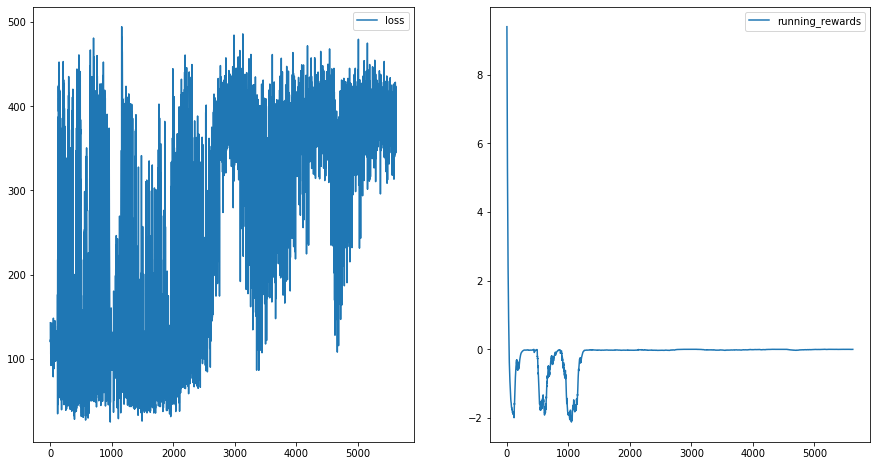

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].plot(losses, label='loss')
ax[0].legend()
ax[1].plot(rewards, label='running_rewards')
ax[1].legend()

dict_keys(['state', 'reward', 'done', 'info', 'state_val', 'action_probs', 'equity', 'prices', 'positions', 'cash', 'margin', 'transactions'])


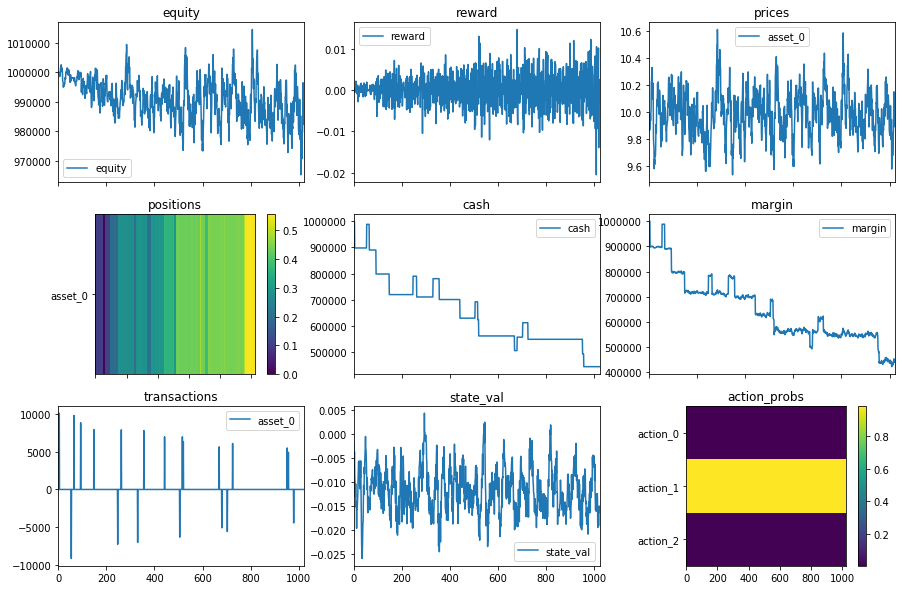

In [176]:
from madigan.utils.plotting import plot_test_metrics
from IPython.core.pylabtools import figsize
figsize(15, 10)
reset=True
# reset=False
agent=policy
tst_metrics = test(agent, env, preprocessor, 
                   nsteps=1024, verbose=True, reset=reset, eps=0.)
print(tst_metrics.keys())

fig, ax = plot_test_metrics(tst_metrics, include=('equity', 'prices', 'cash', 'positions',
                                                 'margin', 'transactions', 'positions', 'action_probs',
                                                  'state_val'))